### Setting up

In [1]:
# Ensures runtime code is updated when source code of libraries are updated as well
%load_ext autoreload
%autoreload 2

In [2]:
# Import of necessary libraries

import pandas as pd
import numpy as np
import pickle
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import gc

# FastAI
from fastai.vision.all import *
from fastai.text.all import *
from fastai.collab import *
from fastai.tabular.all import *

import utils.sp_utils as sp


In [3]:
# User modules

from utils.models import senet
from utils.models import modules
from utils.models import net

In [4]:
# Check if gpu/cuda is available
import torch
torch.cuda.is_available()

True

In [5]:
# Constants
BANDS = [
        'B1: Aerosols',
        'B2: Blue',
        'B3: Green',
        'B4: Red',
        'B5: Red Edge 1',
        'B6: Red Edge 2',
        'B7: Red Edge 3',
        'B8: NIR',
        'B8A: Red Edge 4',
        'B9: Water Vapor',
        'B11: SWIR 1',
        'B12: SWIR 2'
    ]

UMP = ['height_avg_bld', 'height_avg_area', 'height_avg_total', 'height_std',
       'height_max', 'height_percentile', 'planar_index', 'frontal_index']

BATCH_SIZE = 64
CHECKPT_PATH = "pretrained_model/im2elevation/Block0_skip_model_110.pth.tar"

In [6]:
# Import train and validation
with open("data/x_train_tokyo.pkl", "rb") as f:
    x_train = pickle.load(f)

with open("data/x_val_tokyo.pkl", "rb") as f:
    x_val = pickle.load(f)

with open("data/y_train_tokyo.pkl", "rb") as f:
    y_train = pickle.load(f)

with open("data/y_val_tokyo.pkl", "rb") as f:
    y_val = pickle.load(f)

print("Types:", x_train.dtype, x_train.dtype, x_val.dtype, y_val.dtype)

print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}\nx_val shape: {x_val.shape}, y_val shape: {y_val.shape}")

Types: float32 float32 float32 float32
x_train shape: (2628, 12, 91, 91), y_train shape: (2628, 8)
x_val shape: (614, 12, 91, 91), y_val shape: (614, 8)


### Normalising x and y

Normalisation will only be fitted on the training set, and the same parameters will be used for the validation sets

In [7]:
class NDNormalizer:
    def __init__(self, x):
        self.min_x = x.min()
        self.max_x = x.max()
    
    def transform(self, new_x):
        return new_x / self.max_x

    def revert(self, new_x):
        return new_x * self.max_x



In [8]:
x_norms = []
x_train_norm = np.array(x_train)
for channel in range(x_train.shape[1]):
    x_norms.append(NDNormalizer(x_train[:, channel]))
    # x_norms.append(MinMaxScaler().fit(x_train[:, channel]))
    x_train_norm[:, channel] = x_norms[channel].transform(x_train[:, channel])

In [9]:
y_norms = []
y_train_norm = np.array(y_train)
for ump in range(y_train.shape[1]):
    y_norms.append(NDNormalizer(y_train[:, ump]))
    y_train_norm[:, ump] = y_norms[ump].transform(y_train[:, ump])

In [10]:
# DataLoaders for 3 channels in gpu

# Converts into dataloaders
dls_3 = DataLoaders().from_dsets(list(zip(x_train[:, 1:4], y_train)), list(zip(x_val[:, 1:4], y_val)), 
    bs= BATCH_SIZE, device=torch.device('cuda'))

# Check shape
dls_3.one_batch()[0].shape, dls_3.one_batch()[1].shape

(torch.Size([64, 3, 91, 91]), torch.Size([64, 8]))

### Loss Function and Metric

In [11]:
# Loss Function

def mse_weighted(pred, actual, y_norms:List[NDNormalizer]= y_norms):
    """
    Weighted loss function that normalises the predictions based on the parameters used to normalise the actual during training
    """
    loss = tensor(0).float()
    loss.requires_grad_(True)
    for ump in range(pred.shape[1]):
        loss = torch.add(loss, torch.div(F.mse_loss(pred[:, ump], actual[:, ump]), y_norms[ump].max_x**2))
    return loss.float()


In [12]:
# List of metrics
def height_avg_bld_rmse(pred, actual):
    return math.sqrt(F.mse_loss(pred[:, 0], actual[:, 0]))

def height_avg_area_rmse(pred, actual):
    return math.sqrt(F.mse_loss(pred[:, 1], actual[:, 1]))

def height_avg_total_rmse(pred, actual):
    return math.sqrt(F.mse_loss(pred[:, 2], actual[:, 2]))

def height_std_rmse(pred, actual):
    return math.sqrt(F.mse_loss(pred[:, 3], actual[:, 3]))

def height_max_rmse(pred, actual):
    return math.sqrt(F.mse_loss(pred[:, 4], actual[:, 4]))

def height_percentile_rmse(pred, actual):
    return math.sqrt(F.mse_loss(pred[:, 5], actual[:, 5]))

def planar_index_rmse(pred, actual):
    return math.sqrt(F.mse_loss(pred[:, 6], actual[:, 6]))

def frontal_index_rmse(pred, actual):
    return math.sqrt(F.mse_loss(pred[:, 7], actual[:, 7]))

metrics = [
    height_avg_bld_rmse, 
    height_avg_area_rmse,
    height_avg_total_rmse,
    height_std_rmse,
    height_max_rmse,
    height_percentile_rmse,
    planar_index_rmse,
    frontal_index_rmse
]

### Model using Imagenet weights

In [20]:
# ssl to facilitate downloading of weights
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# This is not ideal since we're only working with one feature but we'll try to make it work first
head = create_head(8, 8, ps=0.5)
original_model = senet.senet154()

# original_model = pretrainedmodels.__dict__["sene154"](num_classes=1000, pretrained='imagenet')
# original_model = xse_resnet18() # Check whether it lines up with the number of blockst too
Encoder = modules.E_senet(original_model, x_norms)
im2elevation = net.im2elevation_model(Encoder, num_features=2048, block_channel = [256, 512, 1024, 2048])
model = net.model(im2elevation, head)


TypeError: __init__() missing 1 required positional argument: 'block_channel'

In [ ]:
# Need better loss due to scale difference
learn = Learner(dls_3, model, loss_func= mse_weighted, metrics= metrics)

SuggestedLRs(valley=0.0010000000474974513)

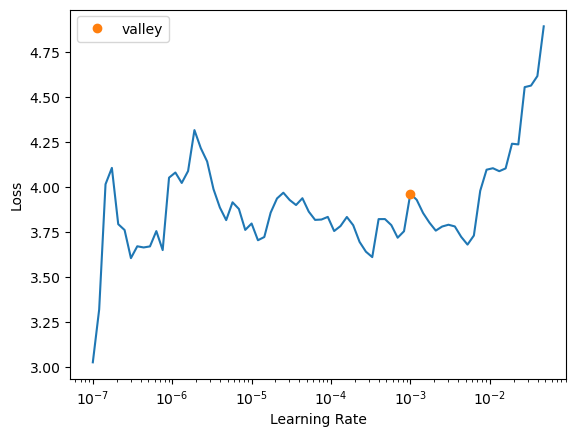

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,height_avg_bld_rmse,height_avg_area_rmse,height_avg_total_rmse,height_std_rmse,height_max_rmse,height_percentile_rmse,planar_index_rmse,frontal_index_rmse,time
0,1.144768,8.236219,7.369600,13.272091,3.698546,21115.280269,52.596954,22.928037,0.778072,0.335740,01:51


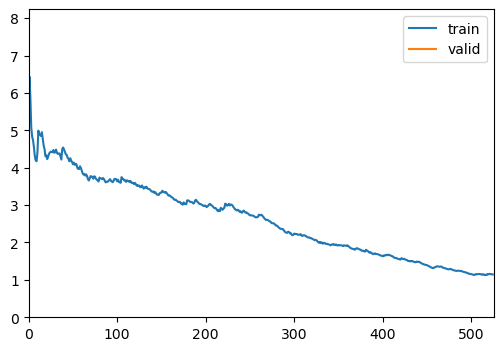

epoch,train_loss,valid_loss,height_avg_bld_rmse,height_avg_area_rmse,height_avg_total_rmse,height_std_rmse,height_max_rmse,height_percentile_rmse,planar_index_rmse,frontal_index_rmse,time
0,0.568570,442.486053,41.536142,42.047627,64.195717,21125.007656,127.565099,169.646370,7.989816,2.653468,01:50
1,0.363761,0.177102,5.231319,11.531877,2.013071,21115.693679,53.144155,22.759610,0.120176,0.131729,01:51
2,0.270457,10.115270,9.072717,24.612670,4.237441,21113.812658,54.661006,21.758470,0.140107,1.265921,01:50
3,0.216142,98.544357,9.248185,14.137300,9.029332,21113.023090,51.447716,31.924863,1.739937,1.016755,01:51
4,0.198586,2.016772,14.706294,19.925047,9.482035,21111.222480,55.682954,42.588120,0.258999,0.239409,01:51


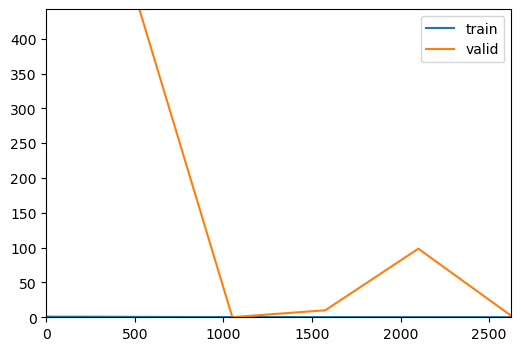

In [ ]:
learn.fine_tune(5, 0.001, cbs= [ShowGraphCallback()])

In [ ]:
# Garbage collection
try:
    del head
    del original_model
    del model
    del Encoder
    del learn
except:
    pass
gc.collect()

0

### Model using IM2ELEVATION weights

In [ ]:
# Load weights from IM2ELEVATION and delete unnecessary layers
checkpoint = torch.load(CHECKPT_PATH)

to_delete = []
for layer in checkpoint["state_dict"].keys():
    if "HARM" in layer.upper():
        to_delete.append(layer)
print(to_delete)

for i in to_delete:
    checkpoint["state_dict"].pop(i)

['E.Harm.dct', 'E.Harm.weight', 'E.Harm.bias']


In [ ]:
# ssl to facilitate downloading of weights
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# This is not ideal since we're only working with one feature but we'll try to make it work first
head = create_head(1, 8, ps=0.5)
original_model = senet.senet154()

Encoder = modules.E_senet(original_model, x_norms)
im2elevation = net.im2elevation_model(Encoder, num_features=2048, block_channel = [256, 512, 1024, 2048])
# Load weights
im2elevation.load_state_dict(checkpoint["state_dict"])

# Clear memory
del checkpoint
gc.collect()

model = net.model(im2elevation, head)


In [ ]:
# Need better loss due to scale difference
learn = Learner(dls_3, model, loss_func= mse_weighted, metrics= metrics)

SuggestedLRs(valley=0.0006918309954926372)

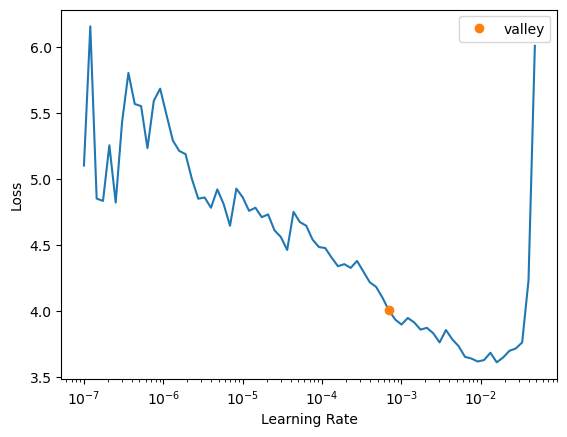

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,height_avg_bld_rmse,height_avg_area_rmse,height_avg_total_rmse,height_std_rmse,height_max_rmse,height_percentile_rmse,planar_index_rmse,frontal_index_rmse,time
0,1.197157,0.205183,8.972118,14.552253,3.386079,21115.745692,56.541666,23.987065,0.122586,0.093377,01:49


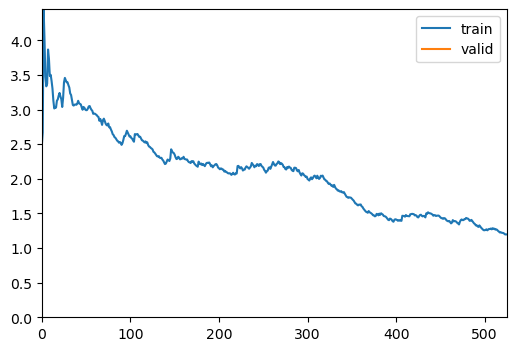

epoch,train_loss,valid_loss,height_avg_bld_rmse,height_avg_area_rmse,height_avg_total_rmse,height_std_rmse,height_max_rmse,height_percentile_rmse,planar_index_rmse,frontal_index_rmse,time
0,0.589979,0.161446,7.710722,11.793797,3.538952,21115.915900,51.436336,19.659477,0.115649,0.149907,01:49
1,0.393729,20.081944,8.179252,26.899431,9.459676,21120.860930,80.993407,32.362608,0.932181,0.657709,01:49
2,0.288193,0.112047,2.543584,8.246302,1.529171,21115.587687,48.684047,17.632258,0.094620,0.111989,01:49
3,0.245179,0.114938,1.801719,6.685369,1.884201,21115.656789,48.277370,16.040765,0.095696,0.108943,01:49
4,0.201782,0.086221,1.923818,6.852827,1.781015,21115.756557,49.908086,16.600140,0.074778,0.084466,01:49


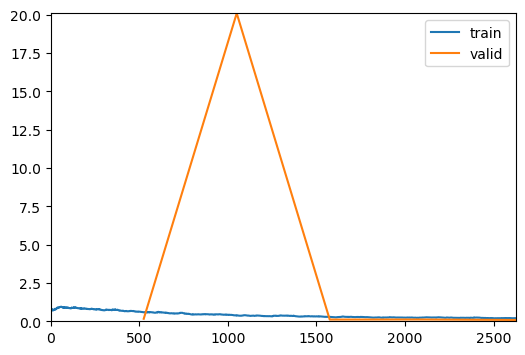

In [ ]:
learn.fine_tune(5, 0.001, cbs= [ShowGraphCallback()])

In [ ]:
# Garbage collection
try:
    del head
    del original_model
    del model
    del Encoder
    del learn
except:
    pass
gc.collect()

### Model using IM2ELEVATION weights 
- Custom head
- Freeze up to R1

In [13]:
# Load weights from IM2ELEVATION and delete unnecessary layers
checkpoint = torch.load(CHECKPT_PATH)

to_delete = []
for layer in checkpoint["state_dict"].keys():
    if any([word in layer.upper() for word in ["HARM", "R.CONV3", "R.BN3", "R.CONV4", "R.BN4"]]):
        to_delete.append(layer)
print(to_delete)

for i in to_delete:
    checkpoint["state_dict"].pop(i)

['E.Harm.dct', 'E.Harm.weight', 'E.Harm.bias', 'R.conv3.weight', 'R.conv3.bias', 'R.bn3.weight', 'R.bn3.bias', 'R.bn3.running_mean', 'R.bn3.running_var', 'R.bn3.num_batches_tracked', 'R.conv4.weight', 'R.conv4.bias']


In [14]:
# ssl to facilitate downloading of weights
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

original_model = senet.senet154()

Encoder = modules.E_senet(original_model, x_norms)
model = net.model(Encoder, num_features=2048, block_channel = [256, 512, 1024, 2048])

# Load trimmed im2elevation weights
model.load_state_dict(checkpoint["state_dict"], strict=False)

_IncompatibleKeys(missing_keys=['R2.conv3.weight', 'R2.conv3.bias', 'R2.bn3.weight', 'R2.bn3.bias', 'R2.bn3.running_mean', 'R2.bn3.running_var', 'R2.conv4.weight', 'R2.conv4.bias', 'R2.bn4.weight', 'R2.bn4.bias', 'R2.bn4.running_mean', 'R2.bn4.running_var', 'R2.conv5.weight', 'R2.conv5.bias', 'R2.head.2.weight', 'R2.head.2.bias', 'R2.head.2.running_mean', 'R2.head.2.running_var', 'R2.head.4.weight', 'R2.head.6.weight', 'R2.head.6.bias', 'R2.head.6.running_mean', 'R2.head.6.running_var', 'R2.head.8.weight'], unexpected_keys=[])

In [15]:
# Clear memory
del checkpoint
gc.collect()
torch.cuda.empty_cache()

In [16]:
L(model.children())[-2:]

(#2) [R1(
  (conv0): Conv2d(208, 144, kernel_size=(1, 1), stride=(1, 1))
  (bn0): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(144, 144, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(144, 144, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
),R2(
  (maxpool0): AdaptiveMaxPool2d(output_size=(46, 46))
  (softmax0): Softmax2d()
  (conv3): Conv2d(432, 288, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(288, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(288, 144, kernel_size=(1, 1), stride=(1, 1))
  (bn4): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(144, 72, kernel_size=(1, 1), stride=(1, 1))
  (head): Sequential(
    (0)

In [17]:
# Need better loss due to scale difference
learn = Learner(dls_3, model, loss_func= mse_weighted, metrics= metrics, cbs=[MixedPrecision, FP16TestCallback])

SuggestedLRs(valley=0.0014454397605732083)

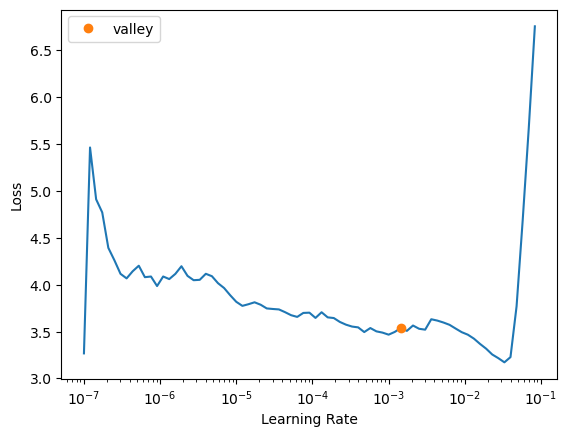

In [18]:
learn.lr_find()

epoch,train_loss,valid_loss,height_avg_bld_rmse,height_avg_area_rmse,height_avg_total_rmse,height_std_rmse,height_max_rmse,height_percentile_rmse,planar_index_rmse,frontal_index_rmse,time
0,3.126842,4.024032,9.359193,16.827737,3.412647,30628.974609,62.456141,28.266288,0.552836,1.437225,00:32


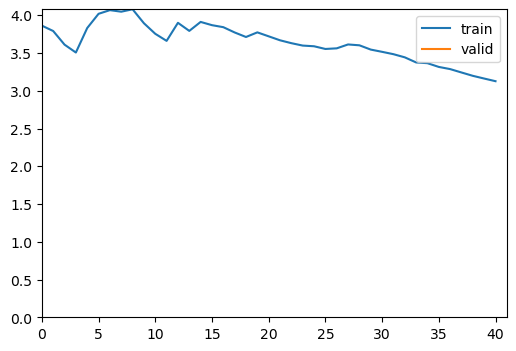

epoch,train_loss,valid_loss,height_avg_bld_rmse,height_avg_area_rmse,height_avg_total_rmse,height_std_rmse,height_max_rmse,height_percentile_rmse,planar_index_rmse,frontal_index_rmse,time
0,1.975782,0.746921,9.691873,16.003075,4.946186,30628.278328,62.597823,26.462200,0.362557,0.255973,00:32
1,1.808107,8.458558,8.525732,13.549639,6.324734,30627.275043,62.100280,24.008689,1.297001,0.520116,00:33
2,1.684834,0.502694,8.454502,13.231829,4.053993,30627.906257,61.389144,23.538539,0.205409,0.481875,00:32
3,1.429103,0.361223,9.657586,15.648823,4.257131,30628.657640,59.931766,25.697431,0.217480,0.161648,00:33
4,1.257441,0.816366,8.944661,13.773351,4.939030,30629.018037,64.006074,23.684550,0.196781,0.613425,00:33
5,1.023864,0.289210,8.560666,12.784605,3.731333,30628.194582,61.250484,22.268400,0.197595,0.099196,00:32
6,0.865928,0.147918,8.730089,14.081646,3.497479,30628.345183,59.622023,23.914258,0.108133,0.119894,00:33
7,0.777982,0.156281,8.565353,13.795603,3.434381,30628.290788,59.646954,23.538545,0.122328,0.091642,00:33
8,0.741258,0.112424,8.507727,13.732759,3.257941,30628.282644,59.362410,23.459036,0.073634,0.077608,00:33
9,0.685616,0.115746,8.466573,13.669604,3.250248,30628.319167,59.426684,23.355929,0.077137,0.079949,00:33


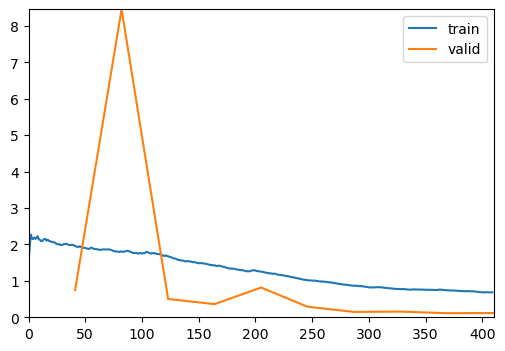

In [19]:
learn.fine_tune(10, 0.001, cbs= [ShowGraphCallback()])

In [24]:
learn.opt

In [26]:
save_model("trained_models/model_customhead.pth", model, opt= learn.opt)

In [20]:
torch.save(model.state_dict(), "trained_models/model_customhead_w_64_10.pth")
torch.save(model, "trained_models/model_customhead_64_10.pth")

In [21]:
# Garbage collection

# del head
del original_model
del model
del Encoder
del learn

In [22]:
gc.collect()
torch.cuda.empty_cache()

In [21]:
del dls_3

In [ ]:
gc.collect()
torch.cuda.empty_cache()